In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from prophet import Prophet
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

2024-05-17 12:31:41.576748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 12:31:41.576840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 12:31:41.677116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Data Loading

In [54]:
df = pd.read_csv(r'/kaggle/input/stocks/all_stocks_5yr.csv')
df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [55]:
# Convert 'date' column to datetime formatz
df['date'] = pd.to_datetime(df['date'])

### Preprocessing

In [56]:
# Sort DataFrame by date (optional, for clarity in plotting)
df.sort_values('date', inplace=True)

In [57]:
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [58]:
# Sort DataFrame by date (optional, for clarity in plotting)
df.sort_values('date', inplace=True)

In [59]:
mean_open = df['open'].mean()
mean_high = df['high'].mean()
mean_low = df['low'].mean()

# Impute missing values with the mean
df['open'].fillna(mean_open, inplace=True)
df['high'].fillna(mean_high, inplace=True)
df['low'].fillna(mean_low, inplace=True)

# Verify that there are no more missing values
print(df.isnull().sum())

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


/tmp/ipykernel_34/6690573.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['open'].fillna(mean_open, inplace=True)
/tmp/ipykernel_34/6690573.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method

### Normalization

In [60]:
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame with numerical columns to be scaled
# Extract numerical columns for scaling
numerical_columns = ['open', 'high', 'low', 'close', 'volume']

# Initialize StandardScaler
scaler = StandardScaler()

In [61]:
# Fit and transform the data
df_scaled = df.copy()  # Create a copy of the DataFrame
df_scaled[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [62]:
df_scaled

,date,open,high,low,close,volume,Name
0,2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL
276739,2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX
266391,2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA
268909,2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP
265132,2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI
...,...,...,...,...,...,...,...
165135,2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI
600154,2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU
325988,2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC
546881,2018-02-07,0.585931,0.612574,0.597926,0.606802,-0.148112,TRV


### Stationarization

In [63]:
# Apply First-Order Differencing to 'close' Prices for Stationarity
df_scaled['diff_close'] = df_scaled['close'].diff(1)
df_scaled

,date,open,high,low,close,volume,Name,diff_close
0,2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL,NaN
276739,2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX,0.077729
266391,2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA,0.152994
268909,2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP,0.097341
265132,2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI,-0.375528
...,...,...,...,...,...,...,...,...
165135,2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI,-0.475204
600154,2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU,-0.275183
325988,2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC,0.853992
546881,2018-02-07,0.585931,0.612574,0.597926,0.606802,-0.148112,TRV,0.405382


In [64]:
df_scaled.isnull().sum()

date          0
open          0
high          0
low           0
close         0
volume        0
Name          0
diff_close    1
dtype: int64

In [65]:
# Fill Null Values after Differencing
df_scaled['diff_close'].fillna(method='bfill', inplace=True)
df_scaled

/tmp/ipykernel_34/522033244.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_scaled['diff_close'].fillna(method='bfill', inplace=True)
/tmp/ipykernel_34/522033244.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_scaled['diff_close'].fillna(method='bfill', inplace=True)


,date,open,high,low,close,volume,Name,diff_close
0,2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL,0.077729
276739,2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX,0.077729
266391,2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA,0.152994
268909,2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP,0.097341
265132,2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI,-0.375528
...,...,...,...,...,...,...,...,...
165135,2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI,-0.475204
600154,2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU,-0.275183
325988,2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC,0.853992
546881,2018-02-07,0.585931,0.612574,0.597926,0.606802,-0.148112,TRV,0.405382


In [66]:
# Calculate IQR for 'diff_close'
Q1 = df_scaled['diff_close'].quantile(0.25)
Q3 = df_scaled['diff_close'].quantile(0.75)
IQR = Q3 - Q1

In [67]:
# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [68]:
# Filter out outliers based on 'diff_close'
df_cleaned = df_scaled[(df_scaled['diff_close'] >= lower_bound) & (df_scaled['diff_close'] <= upper_bound)]

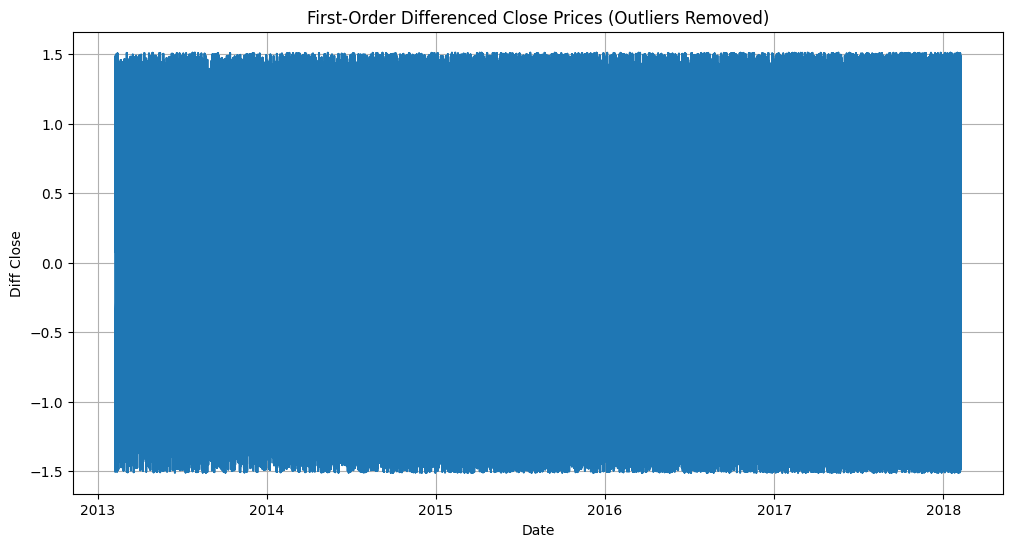

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['date'], df_cleaned['diff_close'])
plt.title('First-Order Differenced Close Prices (Outliers Removed)')
plt.xlabel('Date')
plt.ylabel('Diff Close')
plt.grid(True)
plt.show()

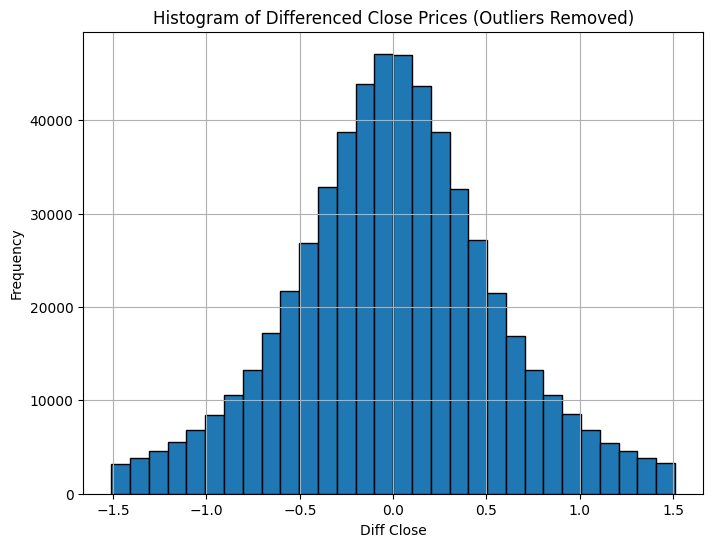

In [70]:
# Histogram of Differenced Close Prices after Outlier Removal (before stationarity check)
plt.figure(figsize=(8, 6))
plt.hist(df_cleaned['diff_close'], bins=30, edgecolor='black')
plt.title('Histogram of Differenced Close Prices (Outliers Removed)')
plt.xlabel('Diff Close')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [71]:
# Check Stationarity Using Dickey-Fuller Test on cleaned data
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')


In [ ]:
# Check stationarity of 'diff_close' after outlier removal
print('Stationarity Test for diff_close (after outlier removal):')
check_stationarity(df_cleaned['diff_close'])

Stationarity Test for diff_close (after outlier removal):


In [ ]:
# Optional: Save the cleaned, stationarized, and outlier-removed DataFrame to a CSV file
df_cleaned.to_csv('cleaned_stationarized_data.csv', index=False)

### Heading to the Modeling

## ARIMA

In [10]:
# reading the new cleaned dataset 
df = pd.read_csv(r'/kaggle/input/stationarised-data-stocks/cleaned_stationarized_data.csv')

In [11]:
df

,date,open,high,low,close,volume,Name,diff_close
0,2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL,0.077729
1,2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX,0.077729
2,2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA,0.152994
3,2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP,0.097341
4,2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI,-0.375528
...,...,...,...,...,...,...,...,...
568326,2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI,-0.475204
568327,2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU,-0.275183
568328,2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC,0.853992
568329,2018-02-07,0.585931,0.612574,0.597926,0.606802,-0.148112,TRV,0.405382


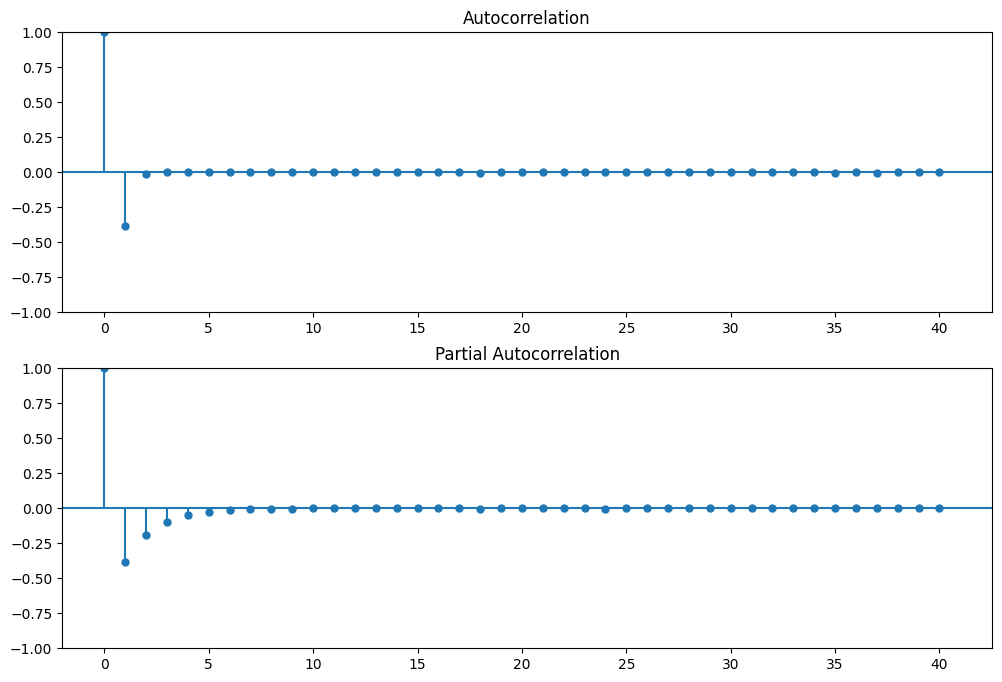

In [12]:
# Plot ACF and PACF for 'diff_close'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['diff_close'], ax=ax1, lags=40)
plot_pacf(df['diff_close'], ax=ax2, lags=40)
plt.show()


In [ ]:


# Calculate ACF and PACF values directly
acf_values, conf_int_acf = acf(df['diff_close'], nlags=40, alpha=0.05)  # Calculate ACF values
pacf_values, conf_int_pacf = pacf(df['diff_close'], nlags=40, alpha=0.05)  # Calculate PACF values

# Find significant lags for p and q
# ACF: Find the first significant drop below the confidence interval
q = np.where(acf_values < conf_int_acf[:, 1])[0][0]

# PACF: Find the first significant drop below the confidence interval
p = np.where(pacf_values < conf_int_pacf[:, 1])[0][0]

# Print identified p and q values
print(f"Identified p value (autoregressive order): {p}")
print(f"Identified q value (moving average order): {q}")

In [13]:
df['date'] = pd.to_datetime(df['date'])
p = q = 1

In [14]:
# Fit ARIMA model with identified parameters
model_arima = ARIMA(df['diff_close'], order=(p, 1, q))


In [15]:
results_arima = model_arima.fit()
print(results_arima.summary())


                               SARIMAX Results                                
Dep. Variable:             diff_close   No. Observations:               568331
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -421954.491
Date:                Fri, 17 May 2024   AIC                         843914.983
Time:                        08:50:55   BIC                         843948.734
Sample:                             0   HQIC                        843924.487
                             - 568331                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3826      0.001   -344.885      0.000      -0.385      -0.380
ma.L1         -1.0000   6.87e-05  -1.46e+04      0.000      -1.000      -1.000
sigma2         0.2585      0.000    584.709      0.0

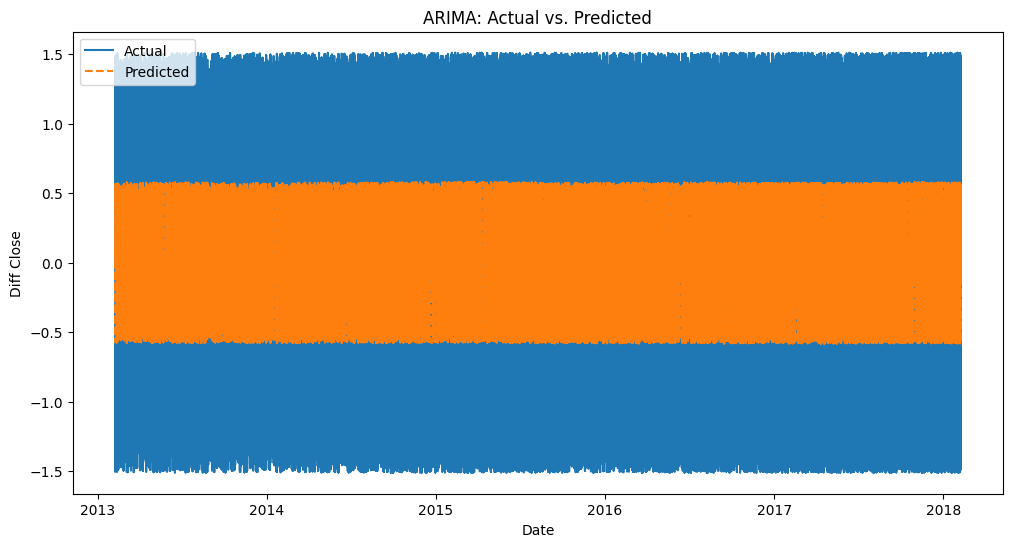

In [16]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['diff_close'], label='Actual')
plt.plot(df['date'], results_arima.fittedvalues, label='Predicted', linestyle='--')
plt.title('ARIMA: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Diff Close')
plt.legend()
plt.show()

In [17]:
# Save ARIMA model
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_arima, f)

In [18]:
# Metrics
arima_mae = mean_absolute_error(df['diff_close'], results_arima.fittedvalues)
arima_mse = mean_squared_error(df['diff_close'], results_arima.fittedvalues)
arima_rmse = np.sqrt(arima_mse)

print(f"ARIMA - Mean Absolute Error: {arima_mae:.4f}")
print(f"ARIMA - Mean Squared Error: {arima_mse:.4f}")
print(f"ARIMA - Root Mean Squared Error: {arima_rmse:.4f}")


ARIMA - Mean Absolute Error: 0.3921
ARIMA - Mean Squared Error: 0.2585
ARIMA - Root Mean Squared Error: 0.5084


# ARTIFICIAL NEURAL NETWORK

In [20]:
numerical_columns = ['open', 'high', 'low', 'close', 'volume']

In [21]:
X = df[numerical_columns]
y = df['diff_close']


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

In [23]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
ann_model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
   99/11367 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.1662

I0000 00:00:1715936047.814074    1130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11367/11367 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.1747 - val_loss: 0.1774
Epoch 2/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1730 - val_loss: 0.1751
Epoch 3/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1734 - val_loss: 0.1755
Epoch 4/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1733 - val_loss: 0.1744
Epoch 5/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1726 - val_loss: 0.1745
Epoch 6/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1729 - val_loss: 0.1749
Epoch 7/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1739 - val_loss: 0.1750
Epoch 8/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1735 - val_loss: 0.1745
Epoch 9/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1723 - val_loss: 0.1752
Epoch 10/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1733 - val_loss: 0.1745
Epoch 11/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1741 - val_loss: 0.1746
Epoch 12

In [27]:
# Predictions and metrics
y_pred_ann = ann_model.predict(X_test_scaled)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [28]:
# Calculate metrics for ANN
ann_mae = mean_absolute_error(y_test, y_pred_ann)
ann_mse = mean_squared_error(y_test, y_pred_ann)
ann_rmse = np.sqrt(ann_mse)

r2 = r2_score(y_test, y_pred_ann)

# Display the calculated metrics
print(f"ANN - MAE: {ann_mae:.4f}\nMSE: {ann_mse:.4f}\nRMSE: {ann_rmse:.4f}")
# \nMAPE: {ann_mape:.4f}
print(f"R-squared (R2): {r2:.4f}")


ANN - MAE: 0.3221
MSE: 0.1740
RMSE: 0.4171
R-squared (R2): 0.4315


In [29]:
# Save ANN model
ann_model.save('ann_model.h5')
with open('ann_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [30]:
# OLS Regression Report
import statsmodels.api as sm

X_ols = sm.add_constant(X)

ols_model = sm.OLS(y, X_ols)
ols_results = ols_model.fit()

print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:             diff_close   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                 7.970e+04
Date:                Fri, 17 May 2024   Prob (F-statistic):               0.00
Time:                        09:11:38   Log-Likelihood:            -3.1596e+05
No. Observations:              568331   AIC:                         6.319e+05
Df Residuals:                  568325   BIC:                         6.320e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1115      0.001    189.579      0.0

## SARIMA (Seasonal ARIMA):

In [ ]:
df = pd.read_csv(r'/kaggle/input/stationarised-data-stocks/cleaned_stationarized_data.csv')

In [ ]:
df

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [ ]:
sarima_model = SARIMAX(df['diff_close'], order=(p, 1, q), seasonal_order=(p, 1, q, 12))

In [ ]:
df.isnull().sum()

In [ ]:
results_sarima = sarima_model.fit()
print(results_sarima.summary())

In [ ]:
# Forecast and plot
forecast_sarima = results_sarima.get_forecast(steps=30)
forecast_mean_sarima = forecast_sarima.predicted_mean
forecast_ci_sarima = forecast_sarima.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(df['diff_close'], label='Actual')
plt.plot(forecast_mean_sarima, label='Forecast', color='red')
plt.fill_between(forecast_ci_sarima.index, forecast_ci_sarima.iloc[:, 0], forecast_ci_sarima.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA: Actual vs. Forecast')
plt.legend()
plt.show()

# Save SARIMA model
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(sarima_model, f)

In [ ]:
# Plot ACF and PACF for differenced series
plt.figure(figsize=(12, 6))
plot_acf(df['diff_close'], lags=40, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of Differenced Series')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['diff_close'], lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of Differenced Series')
plt.show()


In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

# Calculate ACF and PACF values directly for the differenced series (diff_close)
acf_values, conf_int_acf = acf(df['diff_close'].dropna(), nlags=40, alpha=0.05)  # Calculate ACF values
pacf_values, conf_int_pacf = pacf(df['diff_close'].dropna(), nlags=40, alpha=0.05)  # Calculate PACF values

# Find significant lags for p and q (non-seasonal components)
# ACF: Find the first significant drop below the confidence interval
q = np.where(acf_values < conf_int_acf[:, 1])[0][0]

# PACF: Find the first significant drop below the confidence interval
p = np.where(pacf_values < conf_int_pacf[:, 1])[0][0]

# Print identified p and q values (non-seasonal components)
print(f"Identified p value (autoregressive order): {p}")
print(f"Identified q value (moving average order): {q}")

# Calculate seasonal ACF and PACF values for the seasonally differenced series
seasonal_acf_values, seasonal_conf_int_acf = acf(df['diff_close'].diff(12).dropna(), nlags=40, alpha=0.05)  # Calculate seasonal ACF values
seasonal_pacf_values, seasonal_conf_int_pacf = pacf(df['diff_close'].diff(12).dropna(), nlags=40, alpha=0.05)  # Calculate seasonal PACF values

# Find significant lags for P and Q (seasonal components)
# Seasonal ACF: Find the first significant drop below the confidence interval
Q = np.where(seasonal_acf_values < seasonal_conf_int_acf[:, 1])[0][0]

# Seasonal PACF: Find the first significant drop below the confidence interval
P = np.where(seasonal_pacf_values < seasonal_conf_int_pacf[:, 1])[0][0]

# Print identified P and Q values (seasonal components)
print(f"Identified P value (seasonal autoregressive order): {P}")
print(f"Identified Q value (seasonal moving average order): {Q}")

# Determine the order of seasonal differencing (D)
D = 1  # Example: Assume one order of seasonal differencing is needed based on analysis

# Print identified D value (order of seasonal differencing)
print(f"Identified D value (order of seasonal differencing): {D}")


In [ ]:
p = q = d = D = Q = P = 1
m = 12 # for 12 months
# Define SARIMA parameters based on ACF and PACF analysis
order = (p, d, q)  # Non-seasonal parameters
seasonal_order = (P, D, Q, m)  # Seasonal parameters


In [ ]:
# Fit SARIMA model to differenced data
model = SARIMAX(df['diff_close'], order=order, seasonal_order=seasonal_order)
results = model.fit()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create and fit SARIMA model
model = SARIMAX(df['diff_close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Generate forecast
forecast_steps = 30  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Print forecasted mean and confidence intervals
print("Forecasted Mean:")
print(forecast_mean)

print("\nForecasted Confidence Intervals:")
print(forecast_ci)


In [ ]:
# Plot actual vs. forecasted values of the differenced series
plt.figure(figsize=(12, 6))
plt.plot(df['diff_close'], label='Actual Differenced')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Actual vs. Forecasted Values (Differenced Series)')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()


In [ ]:
# Print SARIMA model summary
print(results.summary())

In [ ]:
### SARIMA
sarima_model = SARIMAX(df['diff_close'], order=(p, 1, q), seasonal_order=(p, 1, q, 12))
results_sarima = sarima_model.fit()
print(results_sarima.summary())

# Forecast and plot
forecast_sarima = results_sarima.get_forecast(steps=30)
forecast_mean_sarima = forecast_sarima.predicted_mean
forecast_ci_sarima = forecast_sarima.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(df['diff_close'], label='Actual')
plt.plot(forecast_mean_sarima, label='Forecast', color='red')
plt.fill_between(forecast_ci_sarima.index, forecast_ci_sarima.iloc[:, 0], forecast_ci_sarima.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA: Actual vs. Forecast')
plt.legend()
plt.show()

# Save SARIMA model
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(sarima_model, f)

### Exponential Smoothing (ETS):

In [31]:
df = pd.read_csv(r'/kaggle/input/stationarised-data-stocks/cleaned_stationarized_data.csv')
df

,date,open,high,low,close,volume,Name,diff_close
0,2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL,0.077729
1,2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX,0.077729
2,2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA,0.152994
3,2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP,0.097341
4,2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI,-0.375528
...,...,...,...,...,...,...,...,...
568326,2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI,-0.475204
568327,2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU,-0.275183
568328,2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC,0.853992
568329,2018-02-07,0.585931,0.612574,0.597926,0.606802,-0.148112,TRV,0.405382


In [32]:
df['date'] = pd.to_datetime(df['date'])

In [33]:
df.set_index('date', inplace=True)
df


,open,high,low,close,volume,Name,diff_close
date,,,,,,,
2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL,0.077729
2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX,0.077729
2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA,0.152994
2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP,0.097341
2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI,-0.375528
...,...,...,...,...,...,...,...
2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI,-0.475204
2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU,-0.275183
2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC,0.853992


In [34]:
df.isnull().sum()

open          0
high          0
low           0
close         0
volume        0
Name          0
diff_close    0
dtype: int64

In [35]:
train_size = int(0.8 * len(df))

In [36]:
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [37]:
model_ets = ExponentialSmoothing(train_data['close'], trend='add', seasonal='add', seasonal_periods=12)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [38]:
ets_fit = model_ets.fit()
forecast_ets = ets_fit.forecast(steps=len(test_data))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [39]:
# Step 6: Forecasting
forecast_steps = len(test_data)  # Forecast length same as test set length
forecast_ets = ets_fit.forecast(steps=forecast_steps)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


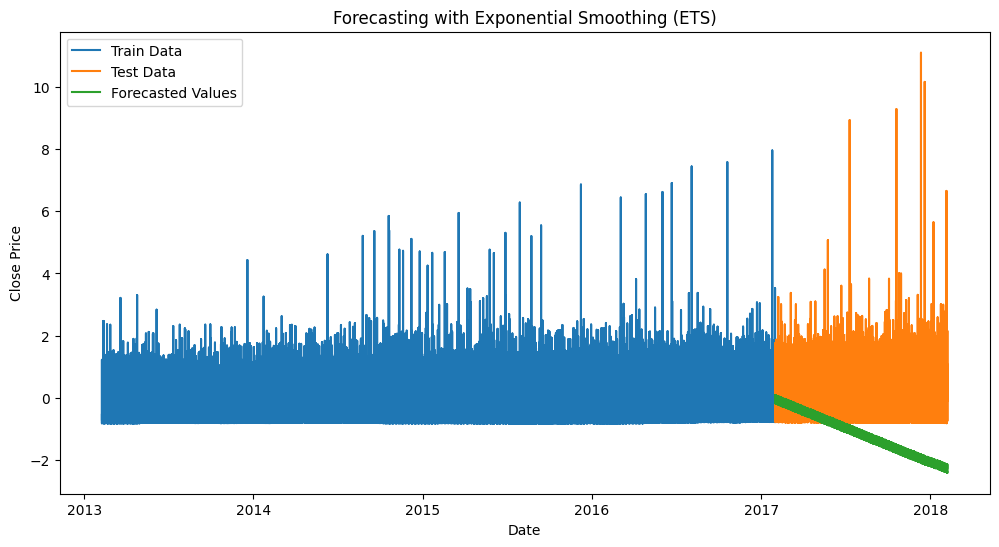

In [40]:
# Step 7: Visualization
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['close'], label='Train Data')
plt.plot(test_data.index, test_data['close'], label='Test Data')
plt.plot(test_data.index, forecast_ets, label='Forecasted Values')
plt.title('Forecasting with Exponential Smoothing (ETS)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [41]:
ets_mse = mean_squared_error(test_data['close'], forecast_ets)
ets_rmse = np.sqrt(ets_mse)
print(f"ETS RMSE: {ets_rmse}")

ETS RMSE: 1.4461446433815321


In [42]:
# Save ETS model
with open('ets_model.pkl', 'wb') as f:
    pickle.dump(model_ets, f)

### Prophet:

In [161]:
df = pd.read_csv(r'/kaggle/input/stationarised-data-stocks/cleaned_stationarized_data.csv')
df

,date,open,high,low,close,volume,Name,diff_close
0,2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL,0.077729
1,2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX,0.077729
2,2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA,0.152994
3,2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP,0.097341
4,2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI,-0.375528
...,...,...,...,...,...,...,...,...
568326,2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI,-0.475204
568327,2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU,-0.275183
568328,2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC,0.853992
568329,2018-02-07,0.585931,0.612574,0.597926,0.606802,-0.148112,TRV,0.405382


In [163]:
df['date'] = pd.to_datetime(df['date'])

In [165]:
# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

11:39:11 - cmdstanpy - INFO - Chain [1] start processing
11:40:20 - cmdstanpy - INFO - Chain [1] done processing


In [166]:
# Generate future dates for forecasting
future_dates = prophet_model.make_future_dataframe(periods=30)
forecast_prophet = prophet_model.predict(future_dates)


In [167]:
# Initialize another Prophet model for forecasting
model = Prophet()
model.fit(prophet_df)

11:40:50 - cmdstanpy - INFO - Chain [1] start processing
11:42:00 - cmdstanpy - INFO - Chain [1] done processing


In [168]:
# Generate future dates for another set of forecasting
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(0.5, 1.0, 'Prophet Forecast')

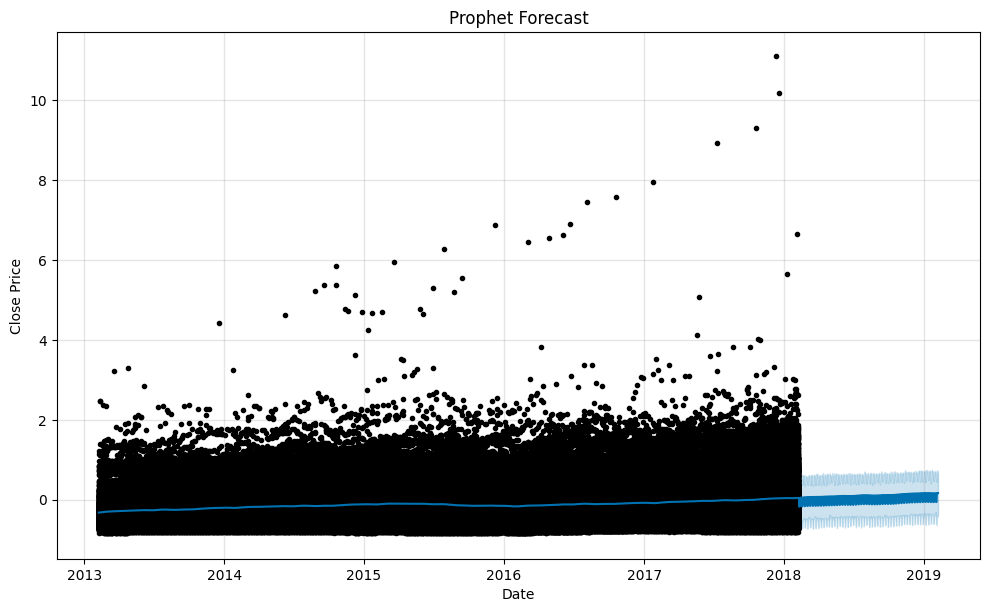

In [169]:
# Plot forecasts
fig = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Prophet Forecast')

In [173]:
# Calculate evaluation metrics
y_true = prophet_df['y'].values
y_pred = forecast_prophet['yhat'].values[:-30]  # Exclude the 30 forecasted days
# prophet_mae = mean_absolute_error(y_true, y_pred)
prophet_mse = mean_squared_error(y_true, y_pred)
prophet_rmse = np.sqrt(prophet_mse)

print(f"Prophet - MAE: {prophet_mae:.4f}, MSE: {prophet_mse:.4f}, RMSE: {prophet_rmse:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [568331, 1259]

In [58]:
# Save Prophet model
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## SVR

In [59]:
df = pd.read_csv(r'/kaggle/input/stationarised-data-stocks/cleaned_stationarized_data.csv')
df

,date,open,high,low,close,volume,Name,diff_close
0,2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL,0.077729
1,2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX,0.077729
2,2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA,0.152994
3,2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP,0.097341
4,2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI,-0.375528
...,...,...,...,...,...,...,...,...
568326,2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI,-0.475204
568327,2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU,-0.275183
568328,2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC,0.853992
568329,2018-02-07,0.585931,0.612574,0.597926,0.606802,-0.148112,TRV,0.405382


In [60]:
X = df[['open', 'high', 'low', 'volume']]  # Include relevant features
y = df['close']  # Target variable

In [61]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
# Instantiate and train the SVR model
svr = SVR(kernel='rbf', C=1.0, gamma='scale')  # Example parameters, adjust as needed
svr.fit(X_train, y_train)


SVR()

In [63]:
# Make predictions
y_pred = svr.predict(X_test)

In [64]:
y_pred_svr = svr.predict(X_test)



In [65]:
svr_mae = mean_absolute_error(y_test, y_pred_svr)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_rmse = np.sqrt(svr_mse)
svr_mape = mean_absolute_percentage_error(y_test, y_pred_svr)

print(f"SVR\nMAE: {svr_mae:.4f}\nMSE: {svr_mse:.4f}\nRMSE: {svr_rmse:.4f}\nMAPE: {svr_mape:.4f}\n")

SVR
MAE: 0.0509
MSE: 0.0034
RMSE: 0.0581
MAPE: 0.9593



In [66]:

# Save SVR model
with open('svr_model.pkl', 'wb') as f:
    pickle.dump(svr, f)

In [67]:
residuals = y_test - y_pred


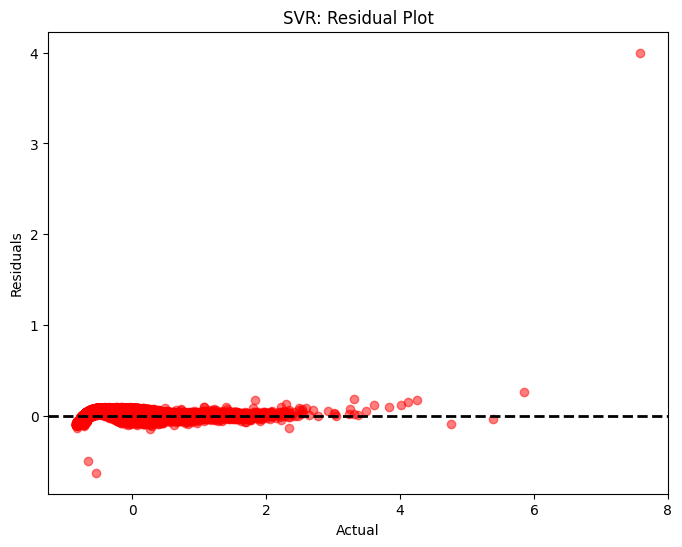

In [68]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='red', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('SVR: Residual Plot')
plt.show()


## LSTM

In [119]:
df

,date,open,high,low,close,volume,Name,diff_close
0,2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL,0.077729
1,2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX,0.077729
2,2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA,0.152994
3,2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP,0.097341
4,2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI,-0.375528
...,...,...,...,...,...,...,...,...
568326,2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI,-0.475204
568327,2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU,-0.275183
568328,2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC,0.853992
568329,2018-02-07,0.585931,0.612574,0.597926,0.606802,-0.148112,TRV,0.405382


In [124]:
df_lstm = df[['date', 'close']]
df_lstm['date'] = pd.to_datetime(df_lstm['date'])
df_lstm.set_index('date', inplace=True)

/tmp/ipykernel_981/2851911602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lstm['date'] = pd.to_datetime(df_lstm['date'])


In [125]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_scaled = scaler.fit_transform(df_lstm)


In [126]:
train_size = int(len(df_lstm_scaled) * 0.8)
train_data, test_data = df_lstm_scaled[:train_size], df_lstm_scaled[train_size:]


In [127]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [128]:
look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)


In [129]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [130]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [131]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 68s 5ms/step - loss: 0.0011
Epoch 2/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 0.0011
Epoch 3/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 0.0011
Epoch 4/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 0.0011
Epoch 5/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.0011
Epoch 6/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 0.0011
Epoch 7/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.0011
Epoch 8/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 0.0011
Epoch 9/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.0011
Epoch 10/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.0011
Epoch 11/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.0011
Epoch 12/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.0011
Epoch 13/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 0.0011
Epoch 14/20
14208/14208 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - 

In [136]:
y_pred_lstm = model_lstm.predict(X_test)
# y_test = scaler.inverse_transform([y_test])
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)


3552/3552 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [138]:
lstm_mae = mean_absolute_error(y_test[0], y_pred_lstm[:, 0])
lstm_mse = mean_squared_error(y_test[0], y_pred_lstm[:, 0])
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_test[0], y_pred_lstm[:, 0])

print(f"LSTM - MAE: {lstm_mae:.4f}, \nMSE: {lstm_mse:.4f}, \nRMSE: {lstm_rmse:.4f}, \nMAPE: {lstm_mape:.4f}")

# Save LSTM model
model_lstm.save('lstm_model.h5')
with open('lstm_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

LSTM - MAE: 0.3792, 
MSE: 0.2651, 
RMSE: 0.5149, 
MAPE: 3.1879


In [142]:
# Comparing Model Performances
model_metrics = pd.DataFrame({
    'Model': ['ARIMA', 'ANN', 'ETS', 'Prophet', 'SVR', 'LSTM'],
    'MAE': [arima_mae, ann_mae,  ets_mse, None, svr_mae, lstm_mae],
    'MSE': [arima_mse, ann_mse, ets_mse, None, svr_mse, lstm_mse],
    'RMSE': [arima_rmse, ann_rmse, ets_rmse, None, svr_rmse, lstm_rmse],
#     'MAPE': [ ann_mape, None, None, svr_mape, lstm_mape]
})

print(model_metrics)

     Model       MAE       MSE      RMSE
0    ARIMA  0.392114  0.258465  0.508395
1      ANN  0.322084  0.173973  0.417101
2      ETS  2.091334  2.091334  1.446145
3  Prophet       NaN       NaN       NaN
4      SVR  0.050876  0.003379  0.058132
5     LSTM  0.379211  0.265093  0.514872


# Hybrid Model

## ARIMA 2

In [2]:
df = pd.read_csv(r'/kaggle/input/stationarised-data-stocks/cleaned_stationarized_data.csv')
df

,date,open,high,low,close,volume,Name,diff_close
0,2013-02-08,-0.697832,-0.699120,-0.700740,-0.701242,0.469964,AAL,0.077729
1,2013-02-08,-0.626768,-0.625550,-0.625926,-0.623513,-0.149572,HOLX,0.077729
2,2013-02-08,-0.469546,-0.471335,-0.467285,-0.470520,-0.282202,HCA,0.152994
3,2013-02-08,-0.375684,-0.377146,-0.371125,-0.373179,-0.139313,HCP,0.097341
4,2013-02-08,-0.749589,-0.749371,-0.748897,-0.748706,-0.024518,HBI,-0.375528
...,...,...,...,...,...,...,...,...
568326,2018-02-07,-0.380203,-0.370120,-0.377032,-0.377389,0.479580,DHI,-0.475204
568327,2018-02-07,-0.649977,-0.648919,-0.651002,-0.652572,0.012534,WU,-0.275183
568328,2018-02-07,0.219215,0.220470,0.205311,0.201420,-0.309508,KLAC,0.853992
568329,2018-02-07,0.585931,0.612574,0.597926,0.606802,-0.148112,TRV,0.405382


In [3]:
df['date'] = pd.to_datetime(df['date'])
# df.isnull().sum()

In [4]:
df.set_index('date', inplace=True)
time_series = df['diff_close']

In [5]:
# Fit ARIMA model
p, d, q = 1, 1, 1  # Identified values from the analysis

In [7]:
arima_model = ARIMA(time_series, order=(p, d, q))
arima_results = arima_model.fit()


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [8]:
# Generate ARIMA predictions
arima_predictions = arima_results.fittedvalues
arima_residuals = time_series - arima_predictions

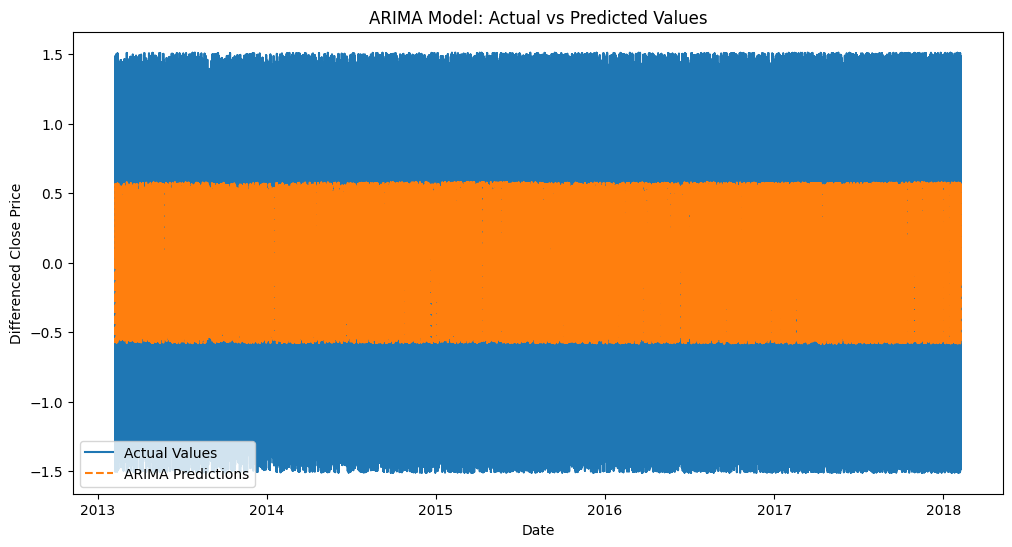

In [9]:
# Plot ARIMA predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Actual Values')
plt.plot(arima_predictions, label='ARIMA Predictions', linestyle='--')
plt.title('ARIMA Model: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

In [ ]:
# Save ARIMA model
with open('arima_model_input_to_ann.pkl', 'wb') as f:
    pickle.dump(arima_model, f)

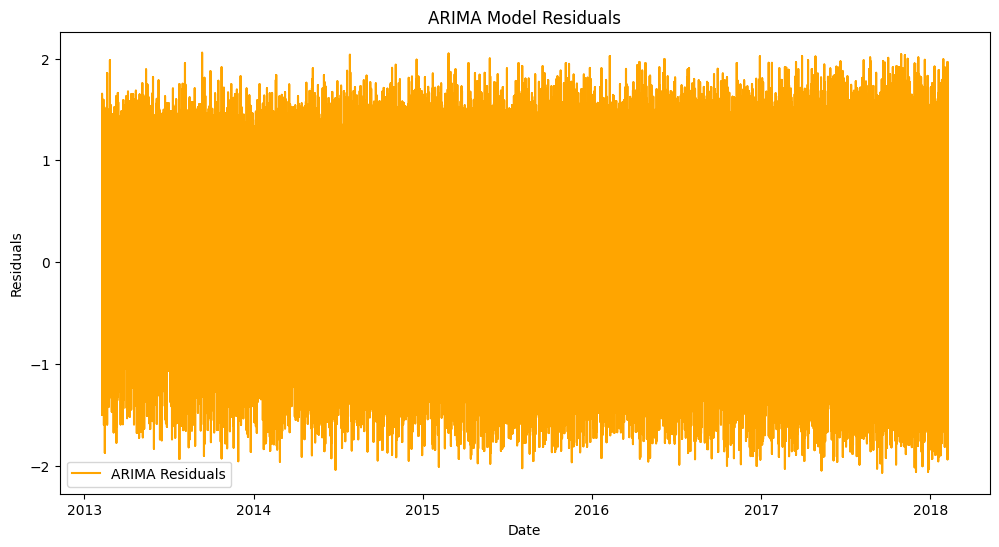

In [10]:
# Plot ARIMA residuals
plt.figure(figsize=(12, 6))
plt.plot(arima_residuals, label='ARIMA Residuals', color='orange')
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [11]:
# Prepare the dataset for ANN
df_features = pd.DataFrame({
    'ARIMA_Predictions': arima_predictions,
    'Residuals': arima_residuals
})

In [12]:
df_features.isnull().sum()

ARIMA_Predictions    0
Residuals            0
dtype: int64

In [13]:
# Extract features and target
X = df_features[['ARIMA_Predictions']]
y = df_features['Residuals']


In [14]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# Define and train ANN model
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
ann_model.compile(optimizer='adam', loss='mean_squared_error')
ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
   92/11367 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.2357

I0000 00:00:1715949310.920850     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11367/11367 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.2455 - val_loss: 0.2493
Epoch 2/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2447 - val_loss: 0.2491
Epoch 3/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2452 - val_loss: 0.2497
Epoch 4/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2442 - val_loss: 0.2488
Epoch 5/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2451 - val_loss: 0.2489
Epoch 6/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2442 - val_loss: 0.2488
Epoch 7/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2456 - val_loss: 0.2487
Epoch 8/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2449 - val_loss: 0.2488
Epoch 9/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2445 - val_loss: 0.2488
Epoch 10/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2449 - val_loss: 0.2489
Epoch 11/50
11367/11367 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2460 - val_loss: 0.2490
Epoch 12

In [ ]:
# Save ANN model
ann_model.save('ann_model_2.h5')

In [18]:
# Generate ANN predictions
ann_residual_predictions = ann_model.predict(X_test_scaled)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


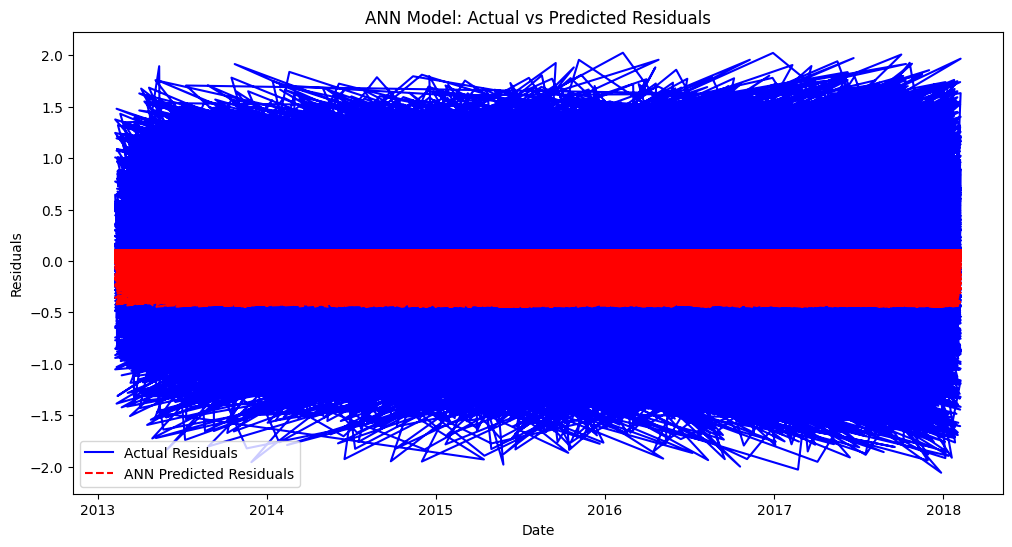

In [19]:
# Plot ANN residual predictions vs actual residuals
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Residuals', color='blue')
plt.plot(y_test.index, ann_residual_predictions, label='ANN Predicted Residuals', linestyle='--', color='red')
plt.title('ANN Model: Actual vs Predicted Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [20]:
# Inspect shapes
print(f"ARIMA Predictions Shape: {arima_predictions.loc[X_test.index].shape}")
print(f"ANN Residual Predictions Shape: {ann_residual_predictions.flatten().shape}")

# Print the first few indices to manually verify alignment
print(f"ARIMA Predictions Indices: {arima_predictions.loc[X_test.index].index[:5]}")
print(f"ANN Test Indices: {X_test.index[:5]}")


ARIMA Predictions Shape: (51325164,)
ANN Residual Predictions Shape: (113667,)
ARIMA Predictions Indices: DatetimeIndex(['2013-12-10', '2013-12-10', '2013-12-10', '2013-12-10',
               '2013-12-10'],
              dtype='datetime64[ns]', name='date', freq=None)
ANN Test Indices: DatetimeIndex(['2013-12-10', '2014-10-21', '2016-01-22', '2014-03-07',
               '2017-12-29'],
              dtype='datetime64[ns]', name='date', freq=None)


In [21]:
# Check the length of the test set to slice the ARIMA predictions accordingly
test_length = len(ann_residual_predictions.flatten())
print(f"Test Length: {test_length}")

Test Length: 113667


In [22]:
# Ensure ARIMA predictions are aligned with the test set and slice accordingly
arima_test_predictions = arima_predictions.loc[X_test.index][:test_length]

In [23]:
# Verify the new shape
print(f"Adjusted ARIMA Predictions Shape: {arima_test_predictions.shape}")
print(f"ANN Residual Predictions Shape: {ann_residual_predictions.flatten().shape}")

Adjusted ARIMA Predictions Shape: (113667,)
ANN Residual Predictions Shape: (113667,)


In [24]:
# Ensure the lengths match
if len(arima_test_predictions) != len(ann_residual_predictions.flatten()):
    raise ValueError("Adjusted lengths of ARIMA test predictions and ANN residual predictions still do not match.")

In [25]:
# Combine ARIMA and ANN predictions
combined_predictions = arima_test_predictions.values + ann_residual_predictions.flatten()


In [ ]:
# # Print the forecasted values
# print("Forecasted Values from the Hybrid Model:")
# for actual, arima_pred, hybrid_pred in zip(y_test[:test_length], arima_test_predictions, combined_predictions):
#     print(f"Actual: {actual:.4f}, ARIMA Prediction: {arima_pred:.4f}, Hybrid Prediction: {hybrid_pred:.4f}")


In [26]:
# Evaluate the combined model
mse = mean_squared_error(y_test[:test_length], combined_predictions)
mae = mean_absolute_error(y_test[:test_length], combined_predictions)
mape = mean_absolute_percentage_error(y_test[:test_length], combined_predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 0.2949
Mean Absolute Error (MAE): 0.4216
Mean Absolute Percentage Error (MAPE): 4.4070
Root Mean Squared Error (RMSE): 0.5430


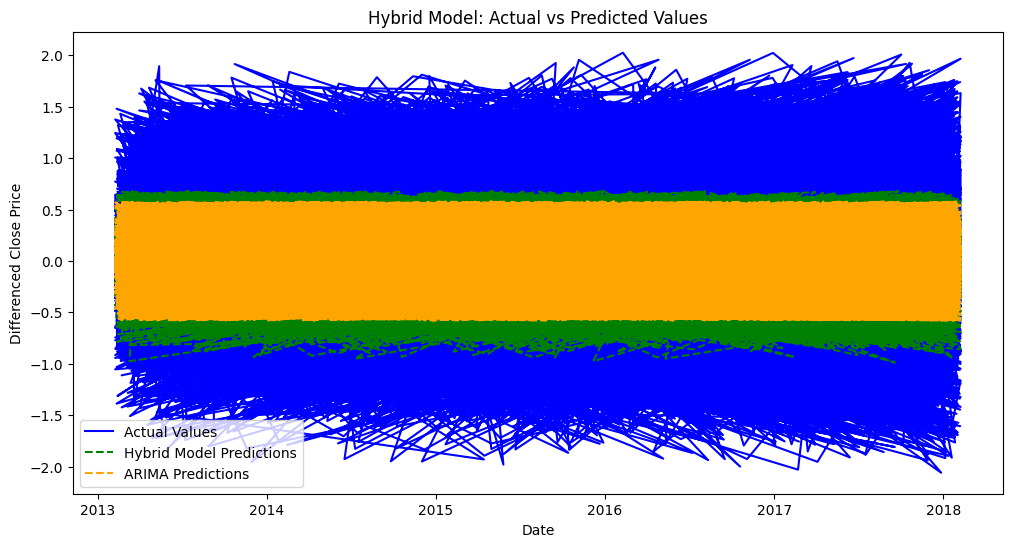

In [27]:
# Plot the combined hybrid model predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:test_length].index, y_test[:test_length], label='Actual Values', color='blue')

plt.plot(y_test[:test_length].index, combined_predictions, label='Hybrid Model Predictions', linestyle='--', color='green')
plt.plot(y_test[:test_length].index, arima_test_predictions, label='ARIMA Predictions', linestyle='--', color='orange')
plt.title('Hybrid Model: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

In [ ]:
with open('hybrid_model_predictions.pkl', 'wb') as f:
    pickle.dump(combined_predictions, f)